In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# Carregando dados
file_path = os.path.join(os.getcwd(), 'propaganda.csv')
df = pd.read_csv(file_path, delimiter=',')

## Regressão simples e múltipla
Tres modelos de regressão simples para comparar as propagandas de TV, rádio e jornal.
Seguindo com um modelo de regressão múltipla

### Análise Descritiva

In [3]:
df.head()

,TV,Radio,Jornal,Vendas
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
df.shape

(200, 4)

In [5]:
df.describe()

,TV,Radio,Jornal,Vendas
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [6]:
df.isna().sum()

TV        0
Radio     0
Jornal    0
Vendas    0
dtype: int64

In [7]:
df.dtypes

TV        float64
Radio     float64
Jornal    float64
Vendas    float64
dtype: object

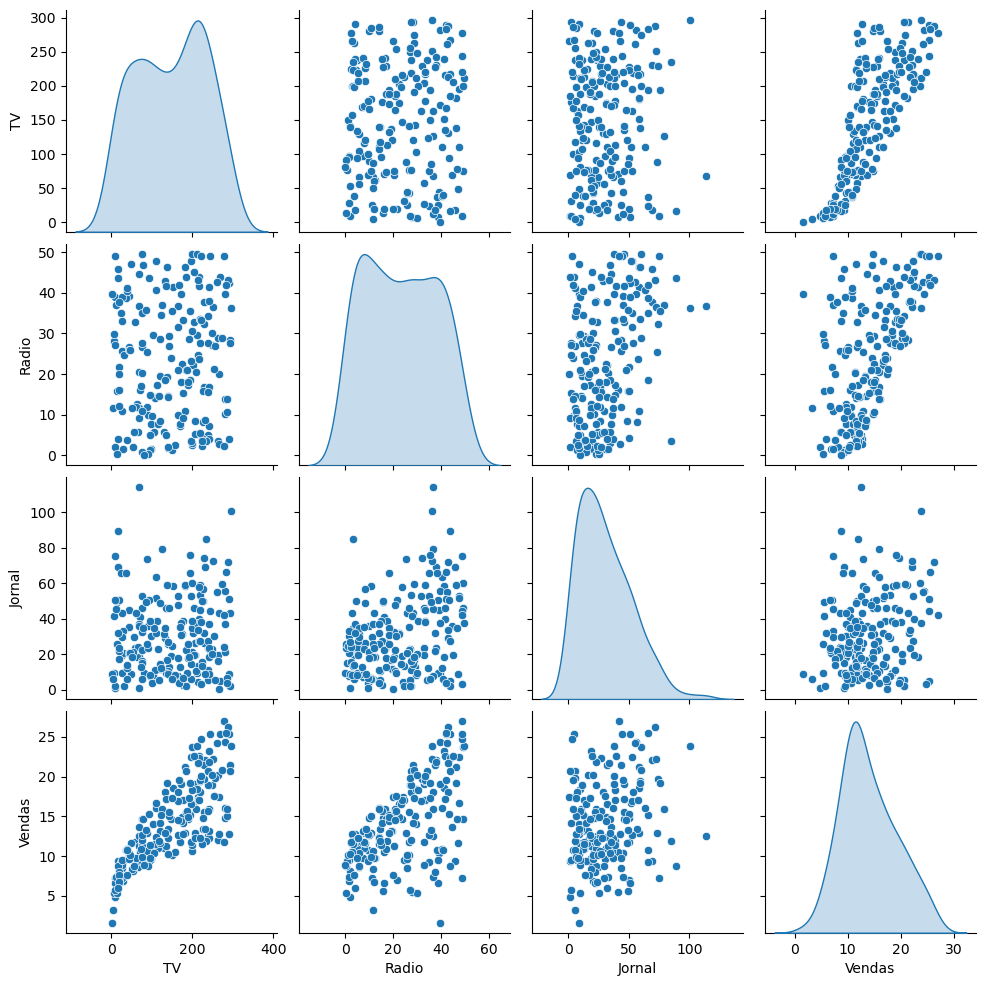

In [8]:
sns.pairplot(df, diag_kind="kde")
plt.show()

### Cálculo de correlação e covariância

In [9]:
correlacao = df['TV'].corr(df['Vendas'])
correlacao

0.7822244248616066

In [10]:
covariancia = df['TV'].cov(df['Vendas'])
covariancia

350.3901947236182

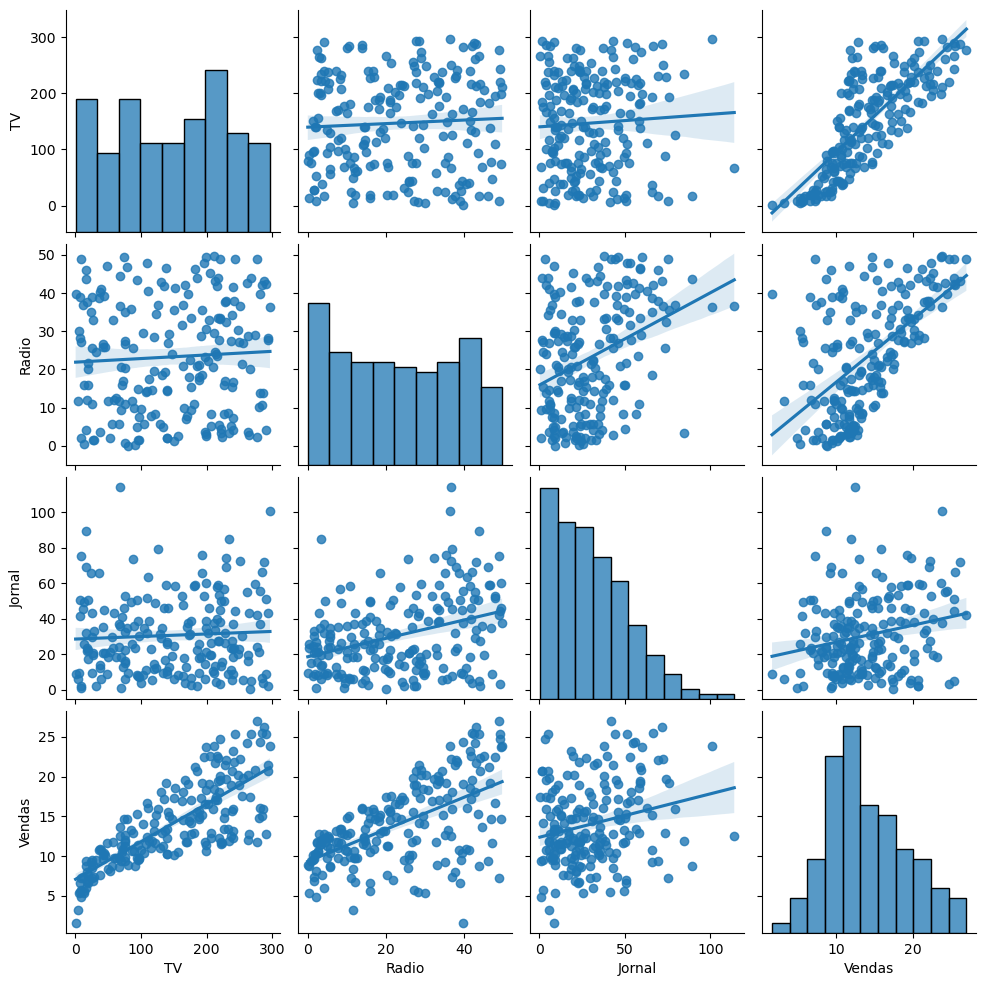

In [11]:
# com regressão
sns.pairplot(df, kind="reg")
plt.show()

In [12]:
variaveis = df[['TV', 'Radio', 'Jornal', 'Vendas']]
variaveis.corr()

,TV,Radio,Jornal,Vendas
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Jornal,0.056648,0.354104,1.000000,0.228299
Vendas,0.782224,0.576223,0.228299,1.000000


In [13]:
import numpy as np
import plotly.figure_factory as ff

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

corr = corr.mask(mask)
fig = ff.create_annotated_heatmap(
    z=corr.to_numpy().round(2),
    x=list(corr.index.values),
    y=list(corr.columns.values),       
    xgap=3, ygap=3,
    zmin=-1, zmax=1,
    colorscale='earth',
    colorbar_thickness=30,
    colorbar_ticklen=3,
)
fig.update_layout(title_text='<b>Correlation Matrix (cont. features)<b>',
                  title_x=0.5,
                  titlefont={'size': 24},
                  width=550, height=550,
                  xaxis_showgrid=False,
                  xaxis={'side': 'bottom'},
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed',                   
                  paper_bgcolor='lightgray',
                  )
fig.show()

/var/folders/5g/z6yykcp555j11_d046fp1h1m0000gn/T/ipykernel_15268/2798387585.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


### Modelo de Regressão

In [14]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm

##### Comparando 3 modelos simples para cada variável da base

In [15]:
X = sm.add_constant(df['TV'])
modelo1 = sm.OLS(df['Vendas'], X).fit()
print(modelo1.summary())

X = sm.add_constant(df['Radio'])
modelo2 = sm.OLS(df['Vendas'], X).fit()
print(modelo2.summary())

X = sm.add_constant(df['Jornal'])
modelo3 = sm.OLS(df['Vendas'], X).fit()
print(modelo3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Vendas   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           1.47e-42
Time:                        21:54:07   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0326      0.458     15.360      0.0

##### Comparando todos os modelos de regressão múltipla

In [16]:
from itertools import combinations
import numpy as np
from typing import List
 
def parse_models(data: pd.DataFrame, target_str:str, variables:List[str]):
    target = data[target_str].tolist()
    todas_combinacoes = []
    results = []
    
    for r in range(1, len(variables) + 1):
        todas_combinacoes.extend(combinations(variables, r))
    comb_str_list = ['+'.join(map(str, comb)) for comb in todas_combinacoes]
    
    for i, campos in enumerate(comb_str_list):
        print(f'Modelo {i}:', campos)
        lm3 = sm.OLS.from_formula(f"{target_str} ~ {campos}", data=data)
        model_cerveja = lm3.fit()
    
        if i == 24 or i == 30:
            print(model_cerveja.summary())
    
        results.append({
            'Modelo': f'Modelo {i}',
            'MAE': np.mean(np.abs(target - model_cerveja.predict())),
            'MSE': np.mean((target - model_cerveja.predict())**2),
            'AIC': model_cerveja.aic,
            'BIC': model_cerveja.bic,
            'R²': model_cerveja.rsquared
        })

    return pd.DataFrame(results)

df_result = parse_models(data=df, target_str='Vendas', variables=['TV', 'Radio', 'Jornal'])
print('\n', df_result)

Modelo 0: TV
Modelo 1: Radio
Modelo 2: Jornal
Modelo 3: TV+Radio
Modelo 4: TV+Jornal
Modelo 5: Radio+Jornal
Modelo 6: TV+Radio+Jornal

      Modelo       MAE        MSE          AIC          BIC        R²
0  Modelo 0  2.549806  10.512653  1042.091328  1048.687962  0.611875
1  Modelo 1  3.320219  18.092398  1150.673780  1157.270415  0.332032
2  Modelo 2  4.146560  25.674023  1220.671352  1227.267986  0.052120
3  Modelo 3  1.253747   2.784570   778.394099   788.289051  0.897194
4  Modelo 4  2.399073   9.592809  1025.778166  1035.673118  0.645835
5  Modelo 5  3.317791  18.074176  1152.472253  1162.367206  0.332705
6  Modelo 6  1.252011   2.784126   780.362236   793.555505  0.897211


##### Utilizando o melhor modelo de regressão múltipla para darmos sequência (Modelo 3)

In [17]:
modelo = smf.ols('Vendas ~ TV + Radio', data=df).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                 Vendas   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Mon, 11 Sep 2023   Prob (F-statistic):           4.83e-98
Time:                        21:54:07   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.0

### Análise de Resíduos

##### Ho = distribuição normal:     p > 0.05

##### Ha = distribuição não normal: p <= 0.05

In [18]:
import scipy.stats as stats

residuos = modelo.resid

estatistica, p = stats.shapiro(residuos)

print("stats :", estatistica)
print("p     :", p)

stats : 0.9180383086204529
p     : 4.190344515819788e-09


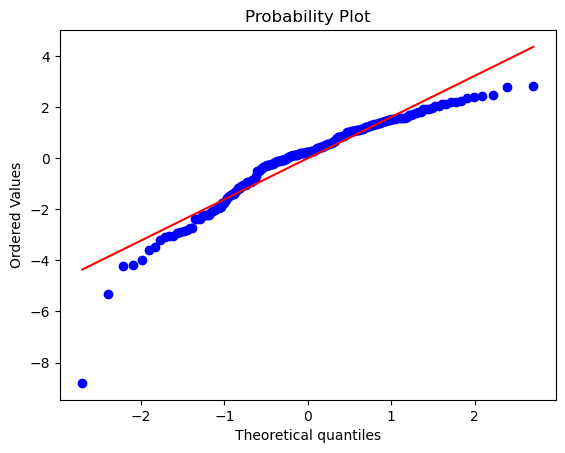

In [19]:
import matplotlib.pyplot as plt

stats.probplot(residuos, dist="norm", plot=plt)
plt.show()

#### Análise da Homocedasticidade dos resíduos
Possúi alguma tendência?

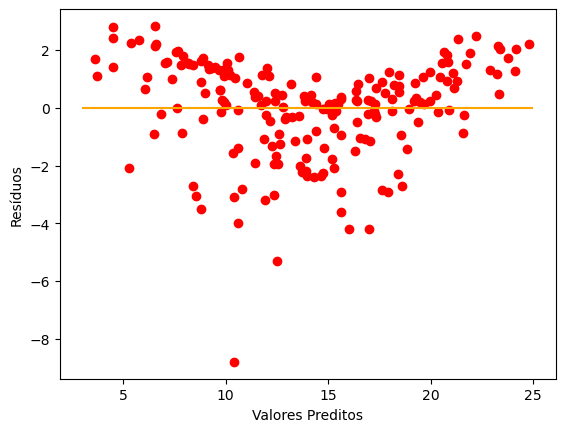

In [20]:
plt.scatter(y=residuos, x=modelo.predict(), color='red')
plt.hlines(y=0, xmin=3, xmax=25, color='orange')
plt.ylabel('Resíduos')
plt.xlabel('Valores Preditos')
plt.show()

#### Teste de Breusch-Pagan (Homodedasticidade ou Heterocedasticidade)

Ho = homocedasticidade: p > 0.05

Ha = heterocedasticidade: p <= 0.05

In [21]:
estatistica, p, f, fp = sms.het_breuschpagan(modelo.resid, modelo.model.exog)
print('Stats :', estatistica)
print('p     :', p)
print('f     :', f)
print('fp    :', fp)

if p > 0.05:
    print('\nO modelo contém homocedasticidade.')
else:
    print('\nO modelo NÃO contém homocedasticidade.')

Stats : 4.809299865939476
p     : 0.09029710011529248
f     : 2.4269395850810556
fp    : 0.09094292734129311

O modelo contém homocedasticidade.


### Análise de Multicolinearidade

Somente entre variáveis independentes.

Considerada multicolinearidade quando r>5 (Neste caso)

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [23]:
vif = add_constant(df[['Jornal', 'TV']])
pd.Series([variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])], index=vif.columns)

const     5.667581
Jornal    1.003219
TV        1.003219
dtype: float64

In [24]:
vif = add_constant(df[['Jornal', 'Radio']])
pd.Series([variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])], index=vif.columns)

const     4.294109
Jornal    1.143366
Radio     1.143366
dtype: float64

In [25]:
vif = add_constant(df[['Radio', 'TV']])
pd.Series([variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])], index=vif.columns)

const    6.135476
Radio    1.003013
TV       1.003013
dtype: float64

In [26]:
X = df[['TV', 'Radio', 'Jornal']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature       VIF
0      TV  2.486772
1   Radio  3.285462
2  Jornal  3.055245


### Análise do Modelo

In [27]:
df['previsao'] = modelo.fittedvalues

In [28]:
df

,TV,Radio,Jornal,Vendas,previsao
0,230.1,37.8,69.2,22.1,20.555465
1,44.5,39.3,45.1,10.4,12.345362
2,17.2,45.9,69.3,9.3,12.337018
3,151.5,41.3,58.5,18.5,17.617116
4,180.8,10.8,58.4,12.9,13.223908
...,...,...,...,...,...
195,38.2,3.7,13.8,7.6,5.364512
196,94.2,4.9,8.1,9.7,8.152375
197,177.0,9.3,6.4,12.8,12.768048
198,283.6,42.0,66.2,25.5,23.792923


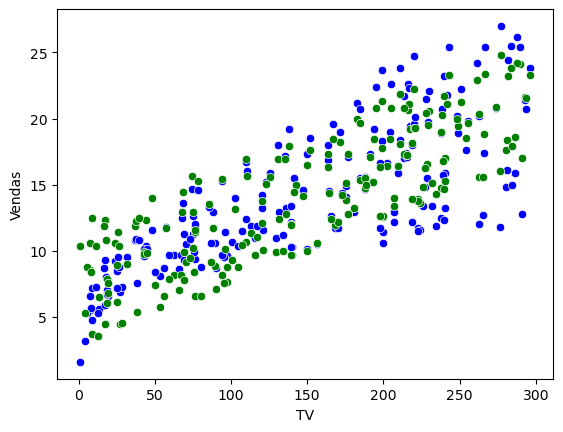

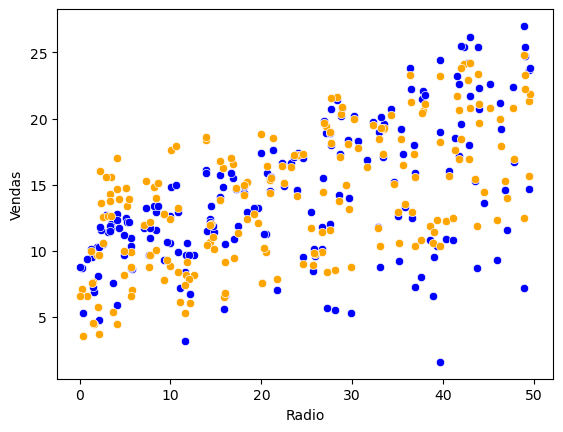

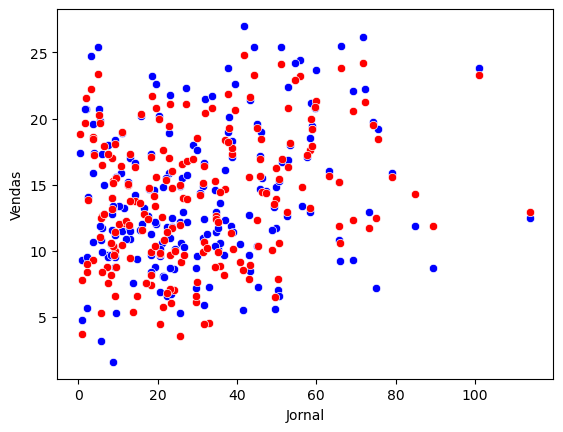

In [29]:
# Comparando previsão com realidade de vendas

sns.scatterplot(x=df.TV, y=df['Vendas'], color='blue')
sns.scatterplot(x=df.TV, y=df['previsao'], color='green')
plt.show()

sns.scatterplot(x=df.Radio, y=df['Vendas'], color='blue')
sns.scatterplot(x=df.Radio, y=df['previsao'], color='orange')
plt.show()

sns.scatterplot(x=df.Jornal, y=df['Vendas'], color='blue')
sns.scatterplot(x=df.Jornal, y=df['previsao'], color='red')
plt.show()